In [1]:
#### ----------------------------------------------------------------
#### author: dhrubas2, date: Jul 21, 2025
#### generate supplementary figures for manuscript 
#### ----------------------------------------------------------------

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import mannwhitneyu
from itertools import product
from functools import reduce
from operator import mul
from math import ceil
from time import time
from plot_functions import (
    make_roc_plot, make_lollipop_plot, make_heatmap, 
    make_barplot3, make_catplot, make_dotplot)
from copy import copy
from warnings import filterwarnings

_wpath_ = "/data/Ruppin_AI/BRCA_PIF/analysis/dhrubas2/"
os.chdir(_wpath_)


In [2]:
#%% read data for supp fig 1.

data_paths = ["../../DataForFigure_V2/HIFs/All_Non_Zero_HIFs/", 
              "../../DataForFigure_V2/nuHIFs/All_Non_Zero_nuHIFs/", 
              "../../DataForFigure_V2/PIFs/All_Non_Zero_PIFs/", 
              "../../DataForFigure_V2/PathAI_NPIFs/All_Non_Zero_PathAI_NPIFs/", 
              "../../DataForFigure_V2/Direct_Features/All_Non_Zero_Direct_Features/", 
              "../../DataForFigure_V2/CPTAC_HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/POST_NAT_HoverNet_NPIFs/All_Non_Zero_NPIFs/"]
data_files = ["combined_class_predictions_all_subtypes_binary.csv", 
              "External_CPTAC_BRCA_Predictions_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Subtypes.csv", 
              "External_POST_NAT_BRCA_Predictions_All_HoverNet_NPIFs_All_Subtypes.csv"]

prob_data_hif    = pd.read_table(
    data_paths[0] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_nuhif  = pd.read_table(
    data_paths[1] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_pif    = pd.read_table(
    data_paths[2] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_npif   = pd.read_table(
    data_paths[3] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_direct = pd.read_table(
    data_paths[4] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_cptac  = pd.read_table(
    data_paths[5] + data_files[1], sep = ",", header = 0, index_col = 0)
prob_data_pnat   = pd.read_table(
    data_paths[6] + data_files[2], sep = ",", header = 0, index_col = 0)

(prob_data_hif.shape, prob_data_nuhif.shape, prob_data_pif.shape, prob_data_npif.shape, 
 prob_data_direct.shape, prob_data_cptac.shape, prob_data_pnat.shape)


((556, 14), (556, 14), (556, 14), (556, 14), (556, 14), (89, 14), (49, 14))

In [3]:
assert sorted(prob_data_hif.columns) == reduce(
    np.intersect1d, [prob_data_hif.columns, prob_data_nuhif.columns, 
                     prob_data_pif.columns, prob_data_npif.columns, 
                     prob_data_direct.columns]).tolist()

prob_data_hif.columns


Index(['true_label_HER2_Positive', 'predicted_probability_HER2_Positive',
       'true_label_HR_Positive', 'predicted_probability_HR_Positive',
       'true_label_TNBC_3', 'predicted_probability_TNBC_3', 'true_label_HR+',
       'predicted_probability_HR+', 'true_label_TNBC_4',
       'predicted_probability_TNBC_4', 'true_label_TPBC',
       'predicted_probability_TPBC', 'true_label_HER2+',
       'predicted_probability_HER2+'],
      dtype='object')

In [4]:
#%% prepare data for supp fig 1.

def get_subtype_dist(data, ncls = 3, aggfunc = "mean", 
                     percent = False):
    if ncls == 3:
        col_map = {"true_label_HER2_Positive" : "HER2+", 
                   "true_label_HR_Positive"   : "HR+", 
                   "true_label_TNBC_3"        : "TNBC"}
    elif ncls == 4:
        col_map = {"true_label_TPBC"   : "TPBC", 
                   "true_label_HER2+"  : "HER2+", 
                   "true_label_HR+"    : "HR+", 
                   "true_label_TNBC_4" : "TNBC"}

    dist = data[
        list(col_map.keys())].rename(
        columns = col_map).apply(
        aggfunc, axis = 0).pipe(
        lambda x: x * 100 if (percent and aggfunc == "mean") else x).convert_dtypes(
        infer_objects = True)

    return dist

## prepare fig data.
# subtypes  = ["HER2_Positive", "HR_Positive", "TNBC_3"]
subtypes  = ["TPBC", "HER2+", "HR+", "TNBC_4"]

## sample distribution.
fig_dataS1B = pd.DataFrame({
    f"{lbl}\n(n = {len(probs):,})": get_subtype_dist(probs, ncls = 4, percent = True) 
    for lbl, probs in zip(["TCGA-BRCA", "CPTAC-BRCA", "POST-NAT-BRCA"], 
                          [prob_data_npif, prob_data_cptac, prob_data_pnat])}).T


## performance across feature types.
data_all  = {"HIFs"  : prob_data_hif, "nuHIFs": prob_data_nuhif, 
             "PIFs"  : prob_data_pif, "NPIFs" : prob_data_npif, 
             "Direct": prob_data_direct}

## compute scores.
aucs_sbtyp  = pd.DataFrame({
    lbl: {sb: roc_auc_score(dat[f"true_label_{sb}"], 
                            dat[f"predicted_probability_{sb}"]) 
          for sb in subtypes} for lbl, dat in data_all.items() })


## prepare fig data.
ds_info = pd.DataFrame([
    {"subtype": sb, "n": prob_data_pif[f"true_label_{sb}"].sum().astype(int)} 
    for sb in subtypes])
ds_info["label"] = ds_info.apply(
    lambda x: f"{x.subtype.split('_')[0]} (n = {x.n})", axis = 1)

mdl_ord    = {"NPIFs" : "NPIFs (m = 12)", 
              "PIFs"  : "PIFs (m = 25)", 
              "HIFs"  : "HIFs (m = 607)", 
              "nuHIFs": "nuHIFs (m = 90)", 
              "Direct": "Direct (m = 512)"}

fig_dataS1C = aucs_sbtyp[
    list(mdl_ord.keys())].set_axis(
    labels = ds_info.label, axis = 0).T.rename(
    index = mdl_ord).reset_index(
    names = "feature").melt(
    id_vars = ["feature"], var_name = "subtype", value_name = "score")

print(f"""
{fig_dataS1B.round(4)}\n
{ds_info}
""")
fig_dataS1C.round(4)



                            TPBC   HER2+      HR+     TNBC
TCGA-BRCA\n(n = 556)     10.4317  4.4964  64.9281  20.1439
CPTAC-BRCA\n(n = 89)      7.8652   5.618  66.2921  20.2247
POST-NAT-BRCA\n(n = 49)  16.3265  4.0816   55.102  24.4898

  subtype    n           label
0    TPBC   58   TPBC (n = 58)
1   HER2+   25  HER2+ (n = 25)
2     HR+  361   HR+ (n = 361)
3  TNBC_4  112  TNBC (n = 112)



,feature,subtype,score
0,NPIFs (m = 12),TPBC (n = 58),0.6612
1,PIFs (m = 25),TPBC (n = 58),0.6155
2,HIFs (m = 607),TPBC (n = 58),0.5815
3,nuHIFs (m = 90),TPBC (n = 58),0.5626
4,Direct (m = 512),TPBC (n = 58),0.5828
5,NPIFs (m = 12),HER2+ (n = 25),0.7432
6,PIFs (m = 25),HER2+ (n = 25),0.7189
7,HIFs (m = 607),HER2+ (n = 25),0.7596
8,nuHIFs (m = 90),HER2+ (n = 25),0.7849
9,Direct (m = 512),HER2+ (n = 25),0.6774


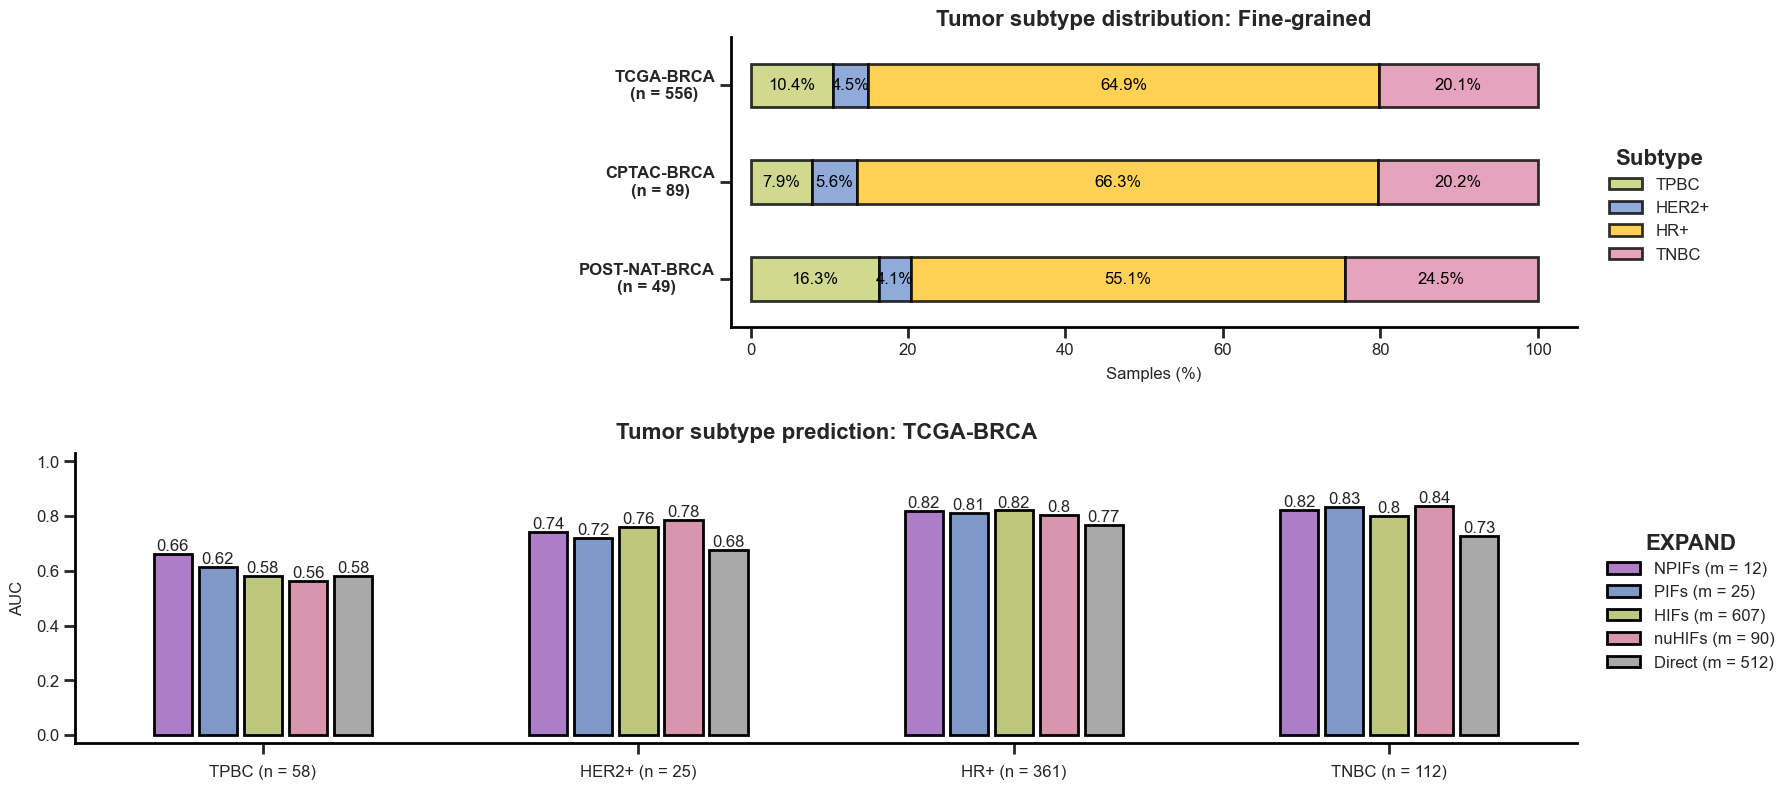

In [5]:
#%% make supp fig 1.

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors      = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
               "#FFC72C", "#708090", "#A9A9A9", "#DFDFDF", "#000000"]

fontdict    = {"label": {"size": 12, "weight": "regular"}, 
               "sbttl": {"size": 14, "weight": "bold"}, 
               "title": {"size": 16, "weight": "bold"}, 
               "super": {"size": 20, "weight": "bold"}, 
               "panel": {"size": 36, "weight": "bold"}}


figS1_II, axS1_II = plt.subplot_mosaic(
    mosaic = [["A", "B", "B"], ["C", "C", "C"]], figsize = (18, 8), 
    height_ratios = [1] * 2, width_ratios = [1, 0.7, 0.7])

## make distribution plot.
fig_colorsS1 = [colors[k] for k in [4, 1, 5, 0]]
fig_titleS1  = "Tumor subtype distribution: Fine-grained"
axS1_II["B"] = make_catplot(data = fig_dataS1B, height = 0.45, annot_fmt = "%0.1f%%", 
                            yticks = "left", title = fig_titleS1, colors = fig_colorsS1, 
                            ax = axS1_II["B"])
axS1_II["B"].set_xlabel("Samples (%)", labelpad = 6, **fontdict["label"]);
axS1_II["B"].axis([-2.5, 105, 2.5, -0.5]);
lh, ll = axS1_II["B"].get_legend_handles_labels()
axS1_II["B"].legend(lh, ll, loc = (1.03, 0.20), ncols = 1, title = "Subtype", 
                    prop = fontdict["label"], title_fontproperties = fontdict["title"]);

## make barplots.
fig_colorsS1 = [colors[k] for k in [3, 1, 4, 0, 7]]
fig_titleS1  = "Tumor subtype prediction: TCGA-BRCA"
axS1_II["C"] = make_barplot3(data = fig_dataS1C, x = "subtype", y = "score", hue = "feature", 
                             width = 0.6, gap = 0.15, bar_labels = True, colors = fig_colorsS1, 
                             title = fig_titleS1, legend = True, legend_title = "EXPAND", 
                             ax = axS1_II["C"])
axS1_II["C"].set_ylabel("AUC", labelpad = 8, **fontdict["label"]);
axS1_II["C"].axis([-0.5, len(subtypes) - 0.5, -0.03, 1.03]);
axS1_II["C"].get_legend().set(bbox_to_anchor = (1.01, 0.20), frame_on = False);

## remove empty plots.
figS1_II.delaxes(axS1_II["A"]);

figS1_II.tight_layout(h_pad = 3, w_pad = 2)
plt.show()


In [6]:
#%% save supp fig 1.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = "All_dataset_summary_subtype_prediction_all_feature_types_4subtypes.pdf"
    out_data  = copy(figS1_II)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving dataset summary plot...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")


In [7]:
#%% read data for supp fig 2.

data_paths = ["../../DataForFigure_V2/HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/Top_Cancer_Tiles/"]
data_files = ["confusion_matrix_all_nuclei_types.csv", 
              "Original_NPIFs2_withSubtypes2.csv", 
              "Spearman_Correlation_with_AUC_top_tiles_V2.csv"]

conf_mat_data  = pd.read_table(data_paths[0] + data_files[0], sep = ",", 
                               header = 0, index_col = 0)
npifs_data     = pd.read_table(data_paths[0] + data_files[1], sep = ",", 
                               header = 0, index_col = 0)
tile_eval_data = pd.read_table(data_paths[1] + data_files[2], sep = ",", 
                               header = 0, index_col = 0)

conf_mat_data.shape, npifs_data.shape, tile_eval_data.shape


((6, 6), (556, 22), (15, 11))

In [8]:
#%% prepare data for supp fig 2.

cell_types = {"Neoplastic"   : "Cancer", 
              "Inflammatory" : "Immune", 
              "Connective"   : "Fibroblast", 
              "Epithelial"   : "Epithelial", 
              "Dead"         : "Dead", 
              "Unknown"      : "Unknown"}

## confusion matrix (true x pred).
fig_dataS2A = conf_mat_data.loc[
    cell_types.keys(), cell_types.keys()].rename(
    index = cell_types, columns = cell_types)


## compute cell-type-specific metrics (macro-average).
fig_dataS2B = { }
for ctp in cell_types.values():
    tp = fig_dataS2A.loc[ctp, ctp]
    fp = fig_dataS2A.loc[:, ctp].sum() - tp
    fn = fig_dataS2A.loc[ctp, :].sum() - tp
    tn = fig_dataS2A.values.sum() - (tp + fp + fn)
    
    fig_dataS2B[ctp] = {
        "Accuracy"    : (tp + tn) / (tp + fp + fn + tn), 
        "Sensitivity" : tp / (tp + fn), 
        "Precision"   : tp / (tp + fp), 
        "F1-score"    : 2 * tp / (2 * tp + fp + fn)}

fig_dataS2B = pd.DataFrame(
    fig_dataS2B).reset_index(
    names = "metric").melt(
    id_vars = "metric", var_name = "cell_type", value_name = "score")

print(fig_dataS2A, end = "\n\n")
print(f"global accuracy = {np.diag(fig_dataS2A).sum() / fig_dataS2A.values.sum():0.4}")
fig_dataS2B.round(4)


            Cancer  Immune  Fibroblast  Epithelial  Dead  Unknown
Cancer        5935     110         153         117     8        8
Immune        1155    5709         543          44   114       34
Fibroblast     604     274        1068          40     6        3
Epithelial     156      27          16          16     0        0
Dead            48      32           3           2    12        0
Unknown        443     435         291          25    46       14

global accuracy = 0.7292


,metric,cell_type,score
0,Accuracy,Cancer,0.8398
1,Sensitivity,Cancer,0.9375
2,Precision,Cancer,0.7115
3,F1-score,Cancer,0.8090
4,Accuracy,Immune,0.8417
5,Sensitivity,Immune,0.7513
6,Precision,Immune,0.8667
7,F1-score,Immune,0.8049
8,Accuracy,Fibroblast,0.8895
9,Sensitivity,Fibroblast,0.5353


In [9]:
#%% prepare data for supp fig 2 - cont'd.

npifs_core  = ["Major Axis", "Minor Axis", "Perimeter", "Area", 
               "Eccentricity", "Circularity"]

fig_dataS2C = tile_eval_data.pipe(
    lambda df: df[df.index.map(lambda x: "AUC" not in x)]).rename(
    index = lambda x: x.replace("Std", "SD")).T.reset_index(
    names = "tile_percent")[::-1]

fig_dataS2D = tile_eval_data.pipe(
    lambda df: df[df.index.map(lambda x: "AUC" in x)]).rename(
    index = lambda x: x.replace("AUC (", "").replace(")", "")).T.reset_index(
    names = "tile_percent")[::-1]

fig_dataS2C


,tile_percent,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,SD Area,SD Major Axis,SD Minor Axis,SD Perimeter,SD Eccentricity,SD Circularity
10,5,0.69,0.73,0.63,0.69,0.81,0.68,0.85,0.88,0.84,0.86,0.76,0.44
9,10,0.77,0.80,0.71,0.77,0.84,0.71,0.89,0.90,0.88,0.89,0.81,0.47
8,15,0.81,0.83,0.75,0.80,0.85,0.72,0.90,0.91,0.90,0.90,0.83,0.47
7,20,0.83,0.85,0.77,0.82,0.86,0.72,0.91,0.92,0.91,0.91,0.84,0.47
6,25,0.84,0.86,0.78,0.83,0.86,0.72,0.92,0.92,0.91,0.91,0.84,0.47
5,30,0.85,0.86,0.79,0.84,0.87,0.72,0.92,0.92,0.92,0.91,0.85,0.47
4,35,0.85,0.87,0.80,0.84,0.87,0.72,0.92,0.92,0.92,0.91,0.85,0.47
3,40,0.85,0.87,0.80,0.85,0.87,0.73,0.92,0.92,0.92,0.91,0.85,0.47
2,45,0.86,0.87,0.81,0.85,0.87,0.73,0.92,0.92,0.92,0.91,0.85,0.47
1,50,0.86,0.87,0.81,0.85,0.87,0.72,0.92,0.92,0.92,0.91,0.85,0.46


In [10]:
#%% prepare data for supp fig 2 - cont'd.

# subtypes = ["HER2_Positive", "HR_Positive", "TNBC_3"]
subtypes = ["TPBC", "HER2+", "HR+", "TNBC_4"]

sb_sizes = npifs_data[subtypes].sum().reset_index().set_axis(
    labels = ["subtype", "n"], axis = 1)
sb_sizes["label"] = sb_sizes.apply(
    lambda x: f"{x.subtype.replace('_Positive', '+').split('_')[0]} (n = {x.n:,})", 
    axis = 1)

## compute association between subtypes & NPIFs (wilcoxon rank-sum test). 
## effect size: rank-biserial correlation, r = 2 * U1 / (n1 * n2)
fig_dataS2E = { }
for sb in subtypes:
    fig_dataS2E[sb] = { }
    for npif in map(
        lambda x: " ".join(x), product(["Mean", "Std"], npifs_core)):
        pdata = npifs_data.groupby(
            by = sb, sort = True).apply(
            lambda df: df[npif].tolist(), include_groups = False).pipe(
            tuple)[::-1]    
        u1, pval  = mannwhitneyu(*pdata, alternative = "two-sided")
        rho, pval = 2 * u1 / mul(*map(len, pdata)) - 1, (
            "****" if pval <= 0.0001 else "*** " if pval <= 0.001 else 
            "**  " if pval <= 0.01 else "*   " if pval <= 0.05 else "")
        
        fig_dataS2E[sb][npif.replace("Std", "SD")] = (rho, pval)
    
    fig_dataS2E[sb] = pd.DataFrame(fig_dataS2E[sb], index = ["rho", "pval"])

fig_dataS2E = pd.concat(fig_dataS2E, axis = 0).T.rename(
    columns = dict(zip(sb_sizes["subtype"], sb_sizes["label"])), 
    level = 0).convert_dtypes()
fig_dataS2E["mean_abs_rho"] = fig_dataS2E.loc[
    :, (slice(None), "rho")].abs().mean(
    axis = 1)
fig_dataS2E.sort_values(
    by = "mean_abs_rho", ascending = False, inplace = True)

fig_dataS2E.round(4)


TPBC (n = 58)       HER2+ (n = 25)       HR+ (n = 361)  \
                            rho  pval            rho  pval           rho   
SD Minor Axis            0.2781  ***          0.4365  ***        -0.4387   
SD Area                   0.241  **           0.4028  ***        -0.4225   
SD Perimeter              0.203  *              0.33  **         -0.4281   
SD Major Axis             0.193  *            0.3466  **         -0.4237   
Mean Major Axis          0.2264  **           0.3103  **          -0.249   
Mean Area                0.2222  **           0.3089  **         -0.2411   
Mean Eccentricity        0.1315               0.3052  **         -0.2501   
Mean Perimeter           0.2154  **           0.2726  *          -0.2304   
SD Circularity           0.1098               0.1819             -0.1959   
Mean Circularity        -0.1054              -0.1324              0.2049   
Mean Minor Axis          0.1921  *            0.2032             -0.1545   
SD Eccentricity          0.0753               0.0762             -0.0469   

                        TNBC (n = 112)       mean_abs_rho  
                   pval            rho  pval               
SD Minor Axis      ****         0.3429  ****       0.3741  
SD Area            ****         0.3506  ****       0.3542  
SD Perimeter       ****         0.3999  ****       0.3403  
SD Major Axis      ****         0.3952  ****       0.3396  
Mean Major Axis    ****         0.1381  *          0.2309  
Mean Area          ****         0.1298  *          0.2255  
Mean Eccentricity  ****         0.1961  **         0.2207  
Mean Perimeter     ****         0.1283  *          0.2117  
SD Circularity     ***          0.1649  **         0.1631  
Mean Circularity   ****        -0.1935  **          0.159  
Mean Minor Axis    **           0.0529             0.1507  
SD Eccentricity                 0.0023             0.0501

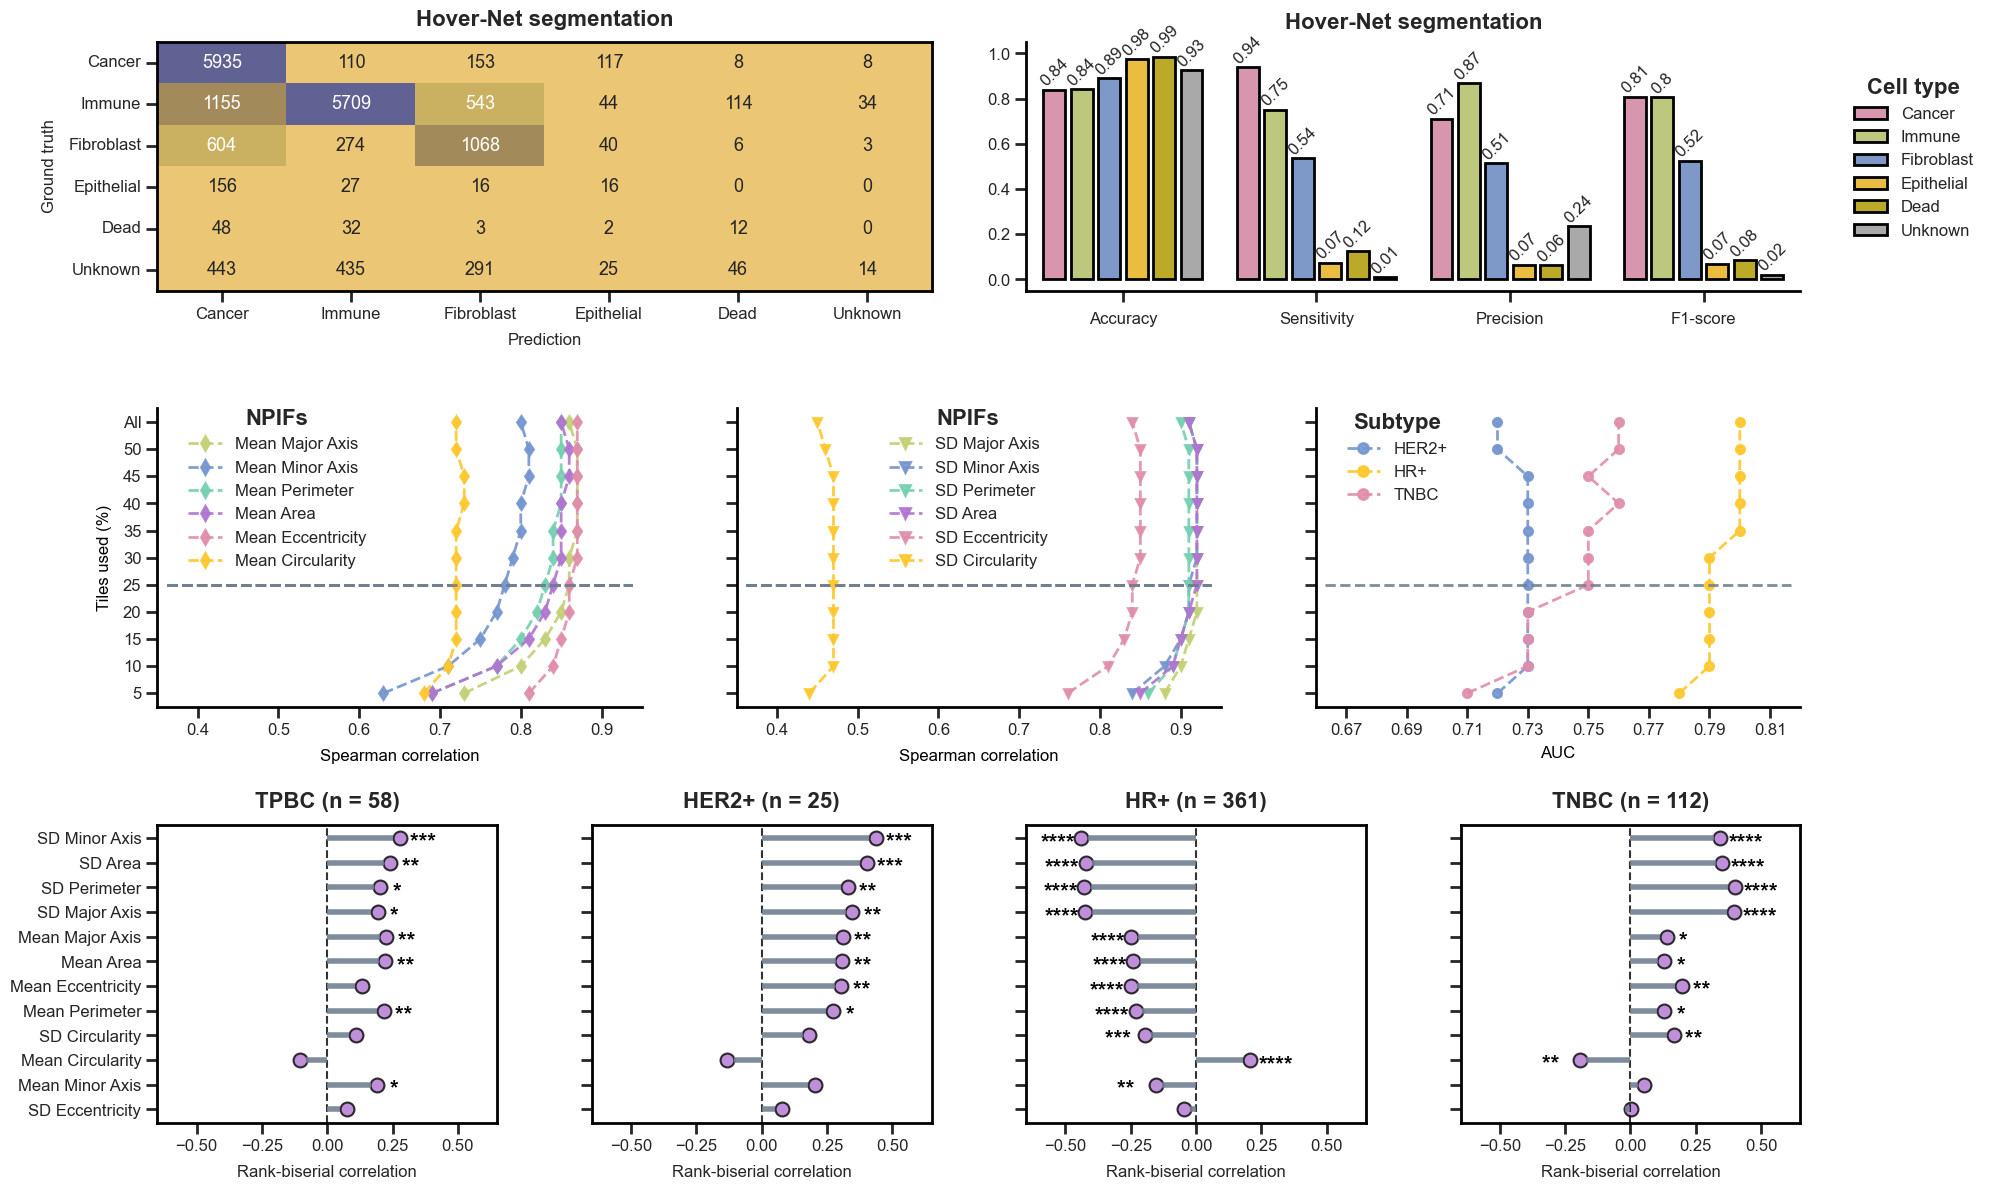

In [11]:
#%% make supp fig 2.

filterwarnings(action = "ignore")

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors       = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
                "#FFC72C", "#CDB816", "#708090", "#A9A9A9", "#000000"]

panel_fonts  = {"weight": "bold", "size": 36, "color": "#000000"}
label_fonts  = {"weight": "regular", "size": 12, "color": "#000000"}
legend_fonts = {"item" : {"size": 12, "weight": "regular"}, 
                "title": {"size": 16, "weight": "bold"}}

ann_props    = {"color": colors[-1], "family": "sans", "size": 16, "weight": "bold", 
                "alpha": 0.99, "ha": "center", "va": "center", "ma": "center", 
                "rotation": None, "wrap": True}
line_prop    = {"linestyle": "--", "linewidth": 2}
mrkr_prop    = {"markersize": 6, "markeredgewidth": 2}


## make composite figure.
figS2, axS2 = plt.subplot_mosaic(
    mosaic = [["A"] * 6 + ["B"] * 6, ["C1"] * 4 + ["C2"] * 4 + ["D"] * 4, 
              ["E1"] * 3 + ["E2"] * 3 + ["E3"] * 3 + ["E4"] * 3], 
    figsize = (20, 12), width_ratios = [1] * 12, height_ratios = [1, 1.2, 1.2])

## HoverNet performance.
fig_titleS2  = "Hover-Net segmentation"

axS2["A"]    = make_heatmap(data = fig_dataS2A, square = False, center = 500, cmap = "tab20b_r", 
                            bold = False, cbar = False, labels = ["Prediction", "Ground truth"], 
                            title = fig_titleS2, ax = axS2["A"])

fig_colorsS2 = [colors[k] for k in [0, 4, 1, 5, 6, 8]]
axS2["B"]    = make_barplot3(data = fig_dataS2B, x = "metric", y = "score", hue = "cell_type", 
                             width = 0.85, gap = 0.2, colors = fig_colorsS2, bar_labels = True, 
                             label_rot = 45, title = fig_titleS2, legend_title = "Cell type", 
                             ax = axS2["B"])
axS2["B"].set_ylim([-0.05, 1.05]);
axS2["B"].get_legend().set(bbox_to_anchor = (1.05, 0.15), frame_on = False);

## optimal threshold. 
## npif - npif2 correlation.
fig_colorsS2 = [colors[k] for k in [4, 1, 2, 3, 0, 5, 7]]
for npif, clr in zip(npifs_core, fig_colorsS2):
    for ax, mrkr, npif_full in zip([axS2["C1"], axS2["C2"]], ["d", "v"], 
                                   [f"Mean {npif}", f"SD {npif}"]):
        ax.plot(npif_full, "tile_percent", data = fig_dataS2C, marker = mrkr, color = clr, 
                alpha = 0.9, **line_prop, **mrkr_prop, label = npif_full)
        ax.axhline(y = 4, xmin = 0.02, xmax = 0.98, color = fig_colorsS2[-1], alpha = 0.9, 
                   **line_prop)
        ax.tick_params(axis = "both", labelsize = label_fonts["size"]);
        ax.set_xlim([0.35, 0.95]);
        ax.set_xlabel("Spearman correlation", labelpad = 8, **label_fonts);
        ax.legend(loc = (0.30 if npif_full.startswith("SD") else 0.05, 0.44), title = "NPIFs", 
                  prop = legend_fonts["item"], title_fontproperties = legend_fonts["title"]);
        
axS2["C1"].set_ylabel("Tiles used (%)", labelpad = 8, **label_fonts);
axS2["C2"].set_yticklabels([""] * len(axS2["C2"].get_yticklabels()));

## subtype-specific auc.
fig_colorsS2 = [colors[k] for k in [1, 5, 0, 7]]
fig_xlimsS2  = np.array([0.66, 0.82])
for sb, clr in zip(fig_dataS2D.columns[1:], fig_colorsS2):
    axS2["D"].plot(sb, "tile_percent", data = fig_dataS2D, marker = "o", color = clr, 
                   alpha = 0.9, **line_prop, **mrkr_prop, label = sb)
axS2["D"].axhline(y = 4, xmin = 0.02, xmax = 0.98, color = fig_colorsS2[-1], alpha = 0.9, 
                  **line_prop)
axS2["D"].tick_params(axis = "both", labelsize = label_fonts["size"]);
axS2["D"].set_xlim(fig_xlimsS2);
axS2["D"].set_xticks(np.arange(*(fig_xlimsS2 + 0.01), 0.02));
axS2["D"].set_yticklabels([""] * len(axS2["D"].get_yticklabels()));
axS2["D"].set_xlabel("AUC", labelpad = 6, **label_fonts);
axS2["D"].legend(loc = (0.05, 0.66), title = "Subtype", prop = legend_fonts["item"], 
                    title_fontproperties = legend_fonts["title"]);

## NPIFs2 - subtype association.
fig_colorsS2 = [colors[k] for k in [3, 7, -1]]
for k, sb in enumerate(sb_sizes["label"], start = 1):
    ax, dat = axS2[f"E{k}"], fig_dataS2E[sb].reset_index(names = "feature")
    ax = make_lollipop_plot(data = dat, x = "rho", y = "feature", width = 4, size = 100, 
                            offset = 0.025, colors = fig_colorsS2, title = sb, 
                            xlabel = "Rank-biserial correlation", ax = ax)
    [ax.annotate(xy   = (dat.rho + (0.10 if dat.rho > 0 else -0.09), y + 0.2), 
                 text = dat.pval, **ann_props) for y, dat in dat.iterrows()];
    if k > 1:    ax.set_yticklabels([""] * len(ax.get_yticklabels()))
    ax.set_xlim([-0.65, 0.65]);


figS2.tight_layout(h_pad = 2, w_pad = 4)
plt.show()


In [12]:
#%% save supp fig 2.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = "TCGA_HoverNet_segmentation_NPIFs2_tile_selection.pdf"
    out_data  = copy(figS2)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving Hover-Net performance plots...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")


In [13]:
#%% read data for supp fig 4.

data_paths = ["../../DataForFigure_V2/PathAI_NPIFs/All_Non_Zero_PathAI_NPIFs/", 
              "../../DataForFigure_V2/HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/CPTAC_HoverNet_NPIFs/All_Non_Zero_NPIFs/", 
              "../../DataForFigure_V2/POST_NAT_HoverNet_NPIFs/All_Non_Zero_NPIFs/"]
data_files = ["combined_class_predictions_all_subtypes_binary.csv", 
              "External_CPTAC_BRCA_Predictions_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Subtypes.csv", 
              "External_POST_NAT_BRCA_Predictions_All_HoverNet_NPIFs_All_Subtypes.csv", 
              "TPBC_foldwise_coefficients.csv", 
              "HER2+_foldwise_coefficients.csv", 
              "HR+_foldwise_coefficients.csv", 
              "TNBC_4_foldwise_coefficients.csv"]

prob_data_tcga0 = pd.read_table(
    data_paths[0] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_tcga  = pd.read_table(
    data_paths[1] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_cptac = pd.read_table(
    data_paths[2] + data_files[1], sep = ",", header = 0, index_col = 0)
prob_data_pnat  = pd.read_table(
    data_paths[3] + data_files[2], sep = ",", header = 0, index_col = 0)

feat_coefs_tcga = pd.concat({
    file.split("_fold")[0]: pd.read_table(
        data_paths[1] + file, sep = ",", header = 0, index_col = 0).rename(
        columns = lambda x: x.replace("Std", "SD")).T
    for file in data_files[3:]}, axis = 1)

assert ((prob_data_tcga0.pipe(lambda df: df.index.tolist() + df.columns.tolist()) == 
         prob_data_tcga.pipe(lambda df: df.index.tolist() + df.columns.tolist())) and 
        (set(prob_data_tcga.columns) == set(prob_data_cptac.columns)) and 
        (set(prob_data_tcga.columns) == set(prob_data_pnat.columns)))

print((prob_data_tcga0.shape, prob_data_tcga.shape, prob_data_cptac.shape, 
       prob_data_pnat.shape))
feat_coefs_tcga.round(4)


((556, 14), (556, 14), (89, 14), (49, 14))


TPBC                                        HER2+  \
                    Fold_1   Fold_2  Fold_3   Fold_4   Fold_5    Fold_1   
Mean Area           0.0000   0.0000  0.0000   0.0000  -0.3934 -145.7397   
Mean Major Axis     3.7114   0.0000  0.0000   0.0000   5.1024   25.2319   
Mean Minor Axis    -3.7950  -0.6599  0.0389  -0.3043  -7.1795  -80.6808   
Mean Perimeter      0.0000   0.0000  0.0000   0.0000   0.0000  162.0142   
Mean Eccentricity   1.9074   2.0328  8.2881   1.4410   0.1221  -20.5013   
Mean Circularity    0.5290  -1.1243  0.7536   0.0000  -0.6378   21.0932   
SD Area             0.0000   0.0000  0.0000   0.0000  10.8263   68.1372   
SD Major Axis       0.0000  -2.8330 -7.4629   0.0000   0.0000  103.4846   
SD Minor Axis      17.1174  13.3764  8.3526  13.4039   9.6071  100.8736   
SD Perimeter      -17.1524  -9.2675  0.0000 -11.4534 -16.7029 -214.1576   
SD Eccentricity    -0.0886   1.5683  4.2599   0.1013   0.3357   -1.0531   
SD Circularity      1.6779   0.1756 -1.4817   1.2137   2.0361    9.5561   

                                                               HR+           \
                     Fold_2    Fold_3    Fold_4    Fold_5   Fold_1   Fold_2   
Mean Area         -131.4675 -127.9547 -168.3240 -131.6310 -10.5702 -10.2938   
Mean Major Axis     41.5925   37.5216   -4.6058   -2.3420  -3.4561 -18.0577   
Mean Minor Axis    -69.0439  -66.2029  -73.0800  -57.5419  42.1614  45.9280   
Mean Perimeter     113.8685  119.9907  198.4517  150.1271 -11.5856  -1.9596   
Mean Eccentricity  -19.8334  -12.0529   -8.0602    0.2254   5.5169   8.9853   
Mean Circularity    17.2437   13.4052   24.0744   26.3690  -0.6137   1.0667   
SD Area             48.2622   86.2671   77.4382   80.5212 -45.3848 -49.2180   
SD Major Axis       46.3108   22.2609   44.8199   57.9535  -0.0554   1.0142   
SD Minor Axis       49.1619   43.2063   52.4748   56.5070  -3.2043  -3.2639   
SD Perimeter      -107.3049 -109.2525 -126.8481 -153.6431  24.8514  31.4081   
SD Eccentricity     -3.1057    0.5085   -0.0041   -4.3120   0.0437   0.5866   
SD Circularity       9.1052    3.6886    5.1145   18.9227  -0.8212  -1.2072   

                                               TNBC_4                    \
                    Fold_3   Fold_4   Fold_5   Fold_1   Fold_2   Fold_3   
Mean Area         -19.0803 -16.2048 -10.6390   5.5388   8.3338   0.0000   
Mean Major Axis   -15.5481 -11.4482 -12.9954   0.0000  -0.2853  -1.8574   
Mean Minor Axis    50.4143  58.1299  43.2250 -14.9095 -16.2984 -11.1208   
Mean Perimeter     -2.1919 -14.9875  -7.4480   0.0000   0.0000   0.0000   
Mean Eccentricity  10.6066  11.0927   9.7838  -5.6140  -5.3278  -3.5498   
Mean Circularity    1.2618  -0.2669  -1.5941   0.0000   0.0365   0.0000   
SD Area           -45.3996 -52.6652 -54.8505  12.5062  12.6152  19.4159   
SD Major Axis       0.6179  -4.1321   1.3867   3.4445   0.0000   0.0000   
SD Minor Axis      -6.1611  -6.4499  -7.8282   0.0000   0.0000   0.0000   
SD Perimeter       30.2182  37.9599  37.1816   0.0000   0.0000   0.0000   
SD Eccentricity     1.8262   1.5667   2.2987  -2.8847  -2.2442  -2.6912   
SD Circularity     -1.0677  -0.7889  -3.3929  -0.6714  -1.7233  -2.8263   

                                     
                    Fold_4   Fold_5  
Mean Area          34.3171   6.1875  
Mean Major Axis     1.4669   0.0000  
Mean Minor Axis   -46.7173 -16.0215  
Mean Perimeter      3.6110   0.0000  
Mean Eccentricity -10.7294  -4.4836  
Mean Circularity   -2.8164  -0.2700  
SD Area            15.4808  15.4929  
SD Major Axis       0.0549   0.6166  
SD Minor Axis       2.4939   0.0000  
SD Perimeter       -3.7634   0.0000  
SD Eccentricity    -2.9674  -1.5727  
SD Circularity     -2.8667  -1.7793

In [14]:
#%% prepare data for supp fig 4.

# subtypes   = ["HER2_Positive", "HR_Positive", "TNBC_3"]
subtypes   = ["TPBC", "HER2+", "HR+", "TNBC_4"]
subtypes   = {sb: sb.replace("_Positive", "+").split("_")[0] for sb in subtypes}

## CV results.
fig_dataS4A = pd.concat([prob_data_tcga0, prob_data_tcga], axis = 0)
fig_dataS4A["feature"] = np.repeat(
    ["NPIFs $-$ selected", "NPIFs $-$ extracted"], repeats = len(fig_dataS4A) / 2)
fig_dataS4A = pd.concat({
    sb_: fig_dataS4A[
        [f"true_label_{sb}", f"predicted_probability_{sb}", "feature"]].set_axis(
        labels = ["label", "pred", "feature"], axis = 1) 
    for sb, sb_ in subtypes.items()}, axis = 1)

## validation results.
fig_dataS4B = pd.concat([prob_data_cptac, prob_data_pnat], axis = 0)
fig_dataS4B["cohort"] = (["CPTAC-BRCA"] * len(prob_data_cptac) + 
                         ["POST-NAT-BRCA"] * len(prob_data_pnat))
fig_dataS4B = pd.concat({
    sb_: fig_dataS4B[
        [f"true_label_{sb}", f"predicted_probability_{sb}", "cohort"]].set_axis(
        labels = ["label", "pred", "cohort"], axis = 1) 
    for sb, sb_ in subtypes.items()}, axis = 1)

## feature importance.
feat_ord   = feat_coefs_tcga.abs().mean(axis = 1).sort_values(ascending = False).index
fig_dataS4C = pd.concat({
    sb_: feat_coefs_tcga.loc[feat_ord, sb].reset_index(
        names = "feature").melt(
        id_vars = "feature", var_name = "model", value_name = "coef")    
    for sb, sb_ in subtypes.items()}, axis = 1)

fig_dataS4C.round(4).head(6)


TPBC                             HER2+                    \
           feature   model     coef          feature   model      coef   
0     SD Perimeter  Fold_1 -17.1524     SD Perimeter  Fold_1 -214.1576   
1        Mean Area  Fold_1   0.0000        Mean Area  Fold_1 -145.7397   
2   Mean Perimeter  Fold_1   0.0000   Mean Perimeter  Fold_1  162.0142   
3  Mean Minor Axis  Fold_1  -3.7950  Mean Minor Axis  Fold_1  -80.6808   
4          SD Area  Fold_1   0.0000          SD Area  Fold_1   68.1372   
5    SD Minor Axis  Fold_1  17.1174    SD Minor Axis  Fold_1  100.8736   

               HR+                              TNBC                   
           feature   model     coef          feature   model     coef  
0     SD Perimeter  Fold_1  24.8514     SD Perimeter  Fold_1   0.0000  
1        Mean Area  Fold_1 -10.5702        Mean Area  Fold_1   5.5388  
2   Mean Perimeter  Fold_1 -11.5856   Mean Perimeter  Fold_1   0.0000  
3  Mean Minor Axis  Fold_1  42.1614  Mean Minor Axis  Fold_1 -14.9095  
4          SD Area  Fold_1 -45.3848          SD Area  Fold_1  12.5062  
5    SD Minor Axis  Fold_1  -3.2043    SD Minor Axis  Fold_1   0.0000

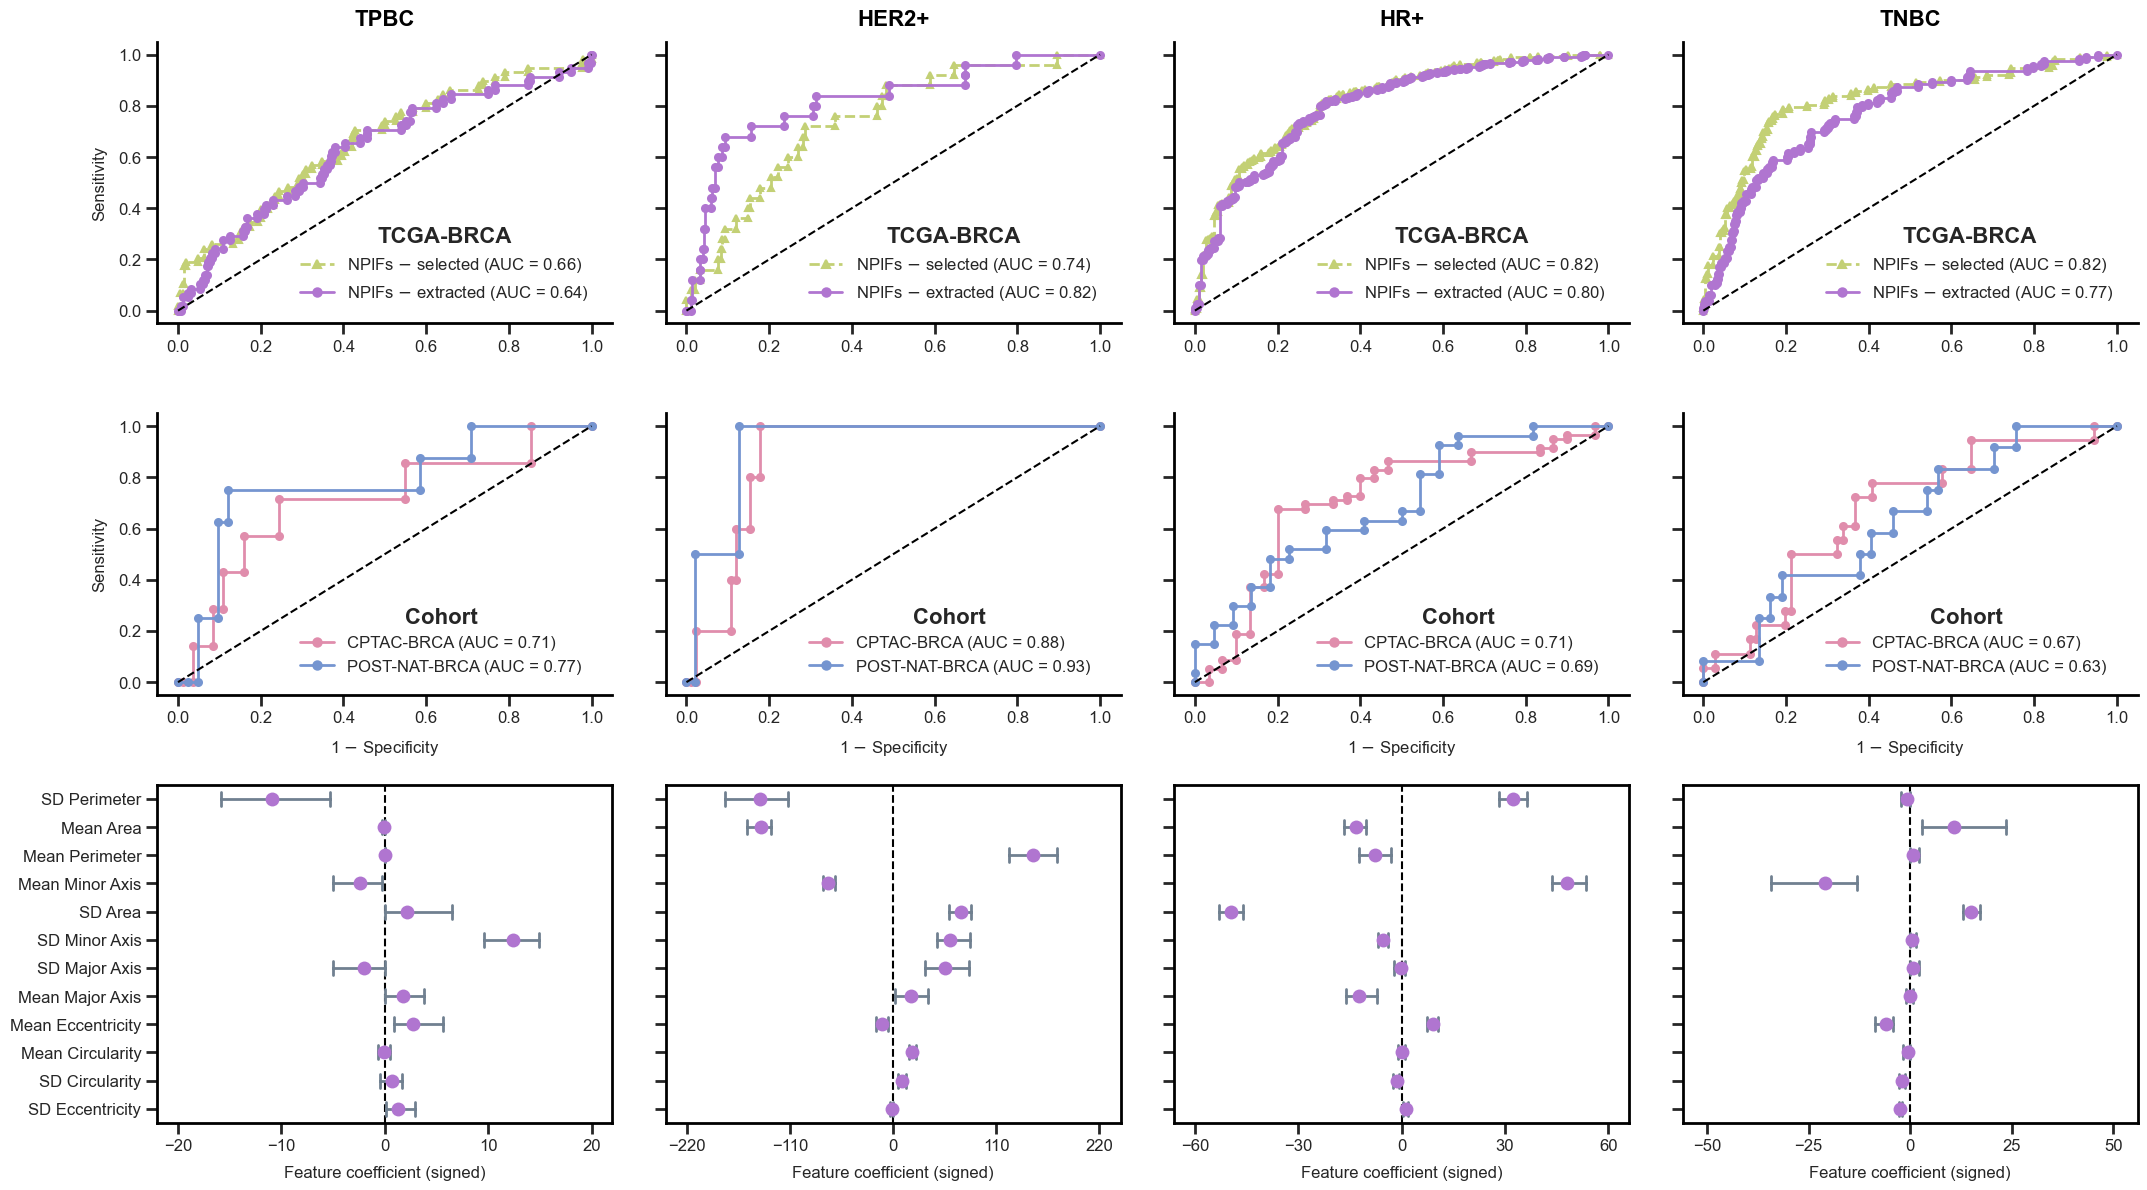

In [15]:
#%% make supp fig 4.

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors       = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
                "#FFC72C", "#708090", "#A9A9A9", "#000000"]

panel_fonts  = {"weight": "bold", "size": 36, "color": "#000000"}
title_fonts  = {"weight": "bold", "size": 16, "color": "#000000"}
label_fonts  = {"weight": "regular", "size": 14, "color": "#000000"}
legend_fonts = {"item" : {"size": 12, "weight": "regular"}, 
                "title": {"size": 16, "weight": "bold"}}

ann_props    = {"color": colors[-1], "family": "sans", "size": 16, 
                "weight": "bold", "alpha": 0.99, "ha": "right", 
                "va": "center", "ma": "center", "rotation": None, 
                "wrap": True}
title_props  = {"wrap": True, "pad": 12, "ha": "center", "va": "center"}
title_props.update(title_fonts)

## make composite figure.
figS4, axS4 = plt.subplots(figsize = (22, 12), nrows = 3, ncols = 4, height_ratios = [1, 1, 1.2])
axS4        = dict(zip(
    ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4", "C1", "C2", "C3", "C4"], axS4.ravel()))

## cross-validation.
fig_colorsS4 = [[colors[k] for k in lst] for lst in [[4, 3, -1], [0, 1, -1], [3, 6, -1]]]
for k, sb in enumerate(subtypes.values(), start = 1):
    ## cross-validation.
    ax, color = axS4[f"A{k}"], fig_colorsS4[0]
    ax = make_roc_plot(data = fig_dataS4A[sb], label = "label", pred = "pred", group = "feature", 
                       colors = color, marker = ["^", "o"], ls = ["--", "-"], ms = 5, 
                       legend_title = "TCGA-BRCA", legend_loc = (0.30, 0.05), ax = ax)
    
    ax.set_title(sb, y = 1.02, **title_props);
    ax.set_xlabel(None)
    if k > 1:
        ax.set_ylabel(None)
        ax.set_yticklabels([""] * len(ax.get_yticklabels()));
    
    ## external validation.
    ax, color = axS4[f"B{k}"], fig_colorsS4[1]
    ax = make_roc_plot(data = fig_dataS4B[sb], label = "label", pred = "pred", group = "cohort", 
                       colors = color, ms = 5, legend_title = "Cohort", legend_loc = (0.30, 0.05), 
                       ax = ax)

    if k > 1:
        ax.set_ylabel(None)
        ax.set_yticklabels([""] * len(ax.get_yticklabels()));
    
    ## feature importance.
    ax, color = axS4[f"C{k}"], fig_colorsS4[2]
    ax = make_dotplot(data = fig_dataS4C[sb], x = "coef", y = "feature", ebar = ("ci", 95), 
                      ecap = 0.5, yticks = "left", ms = 10, mew = 0, colors = color, 
                      xlabel = "Feature coefficient (signed)", ax = ax)

    xm = ceil(fig_dataS4C[(sb, "coef")].abs().max() / 10) * 10
    ax.set_xlim(-ceil(xm * 1.1), ceil(xm * 1.1));
    ax.set_xticks(np.linspace(-xm, xm, num = 5));
    if k > 1:
        ax.set_ylabel(None)
        ax.set_yticklabels([""] * len(ax.get_yticklabels()));

figS4.tight_layout(h_pad = 2, w_pad = 0)
plt.show()


In [16]:
#%% save supp fig 4.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = "All_NPIFs_validation_feature_importance_4subtypes.pdf"
    out_data  = copy(figS4)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving performance plots for NPIFs2...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")


In [17]:
#%% read data for supp fig 5.

data_paths = ["../../DataForFigure_V2/HoverNet_Immune_NPIFs/Top25_Percent_Tiles/TCGA_BRCA/", 
              "../../DataForFigure_V2/HoverNet_Immune_NPIFs/Top25_Percent_Tiles/CPTAC_BRCA/", 
              "../../DataForFigure_V2/HoverNet_Immune_NPIFs/Top25_Percent_Tiles/POST_NAT_BRCA/", 
              "../../DataForFigure_V2/HoverNet_Immune_NPIFs/All_Tiles/TCGA_BRCA/", 
              "../../DataForFigure_V2/HoverNet_Immune_NPIFs/All_Tiles/CPTAC_BRCA/", 
              "../../DataForFigure_V2/HoverNet_Immune_NPIFs/All_Tiles/POST_NAT_BRCA/"]
data_files = ["combined_class_predictions_all_subtypes_binary.csv", 
              "External_CPTAC_BRCA_Predictions_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Immune_Only_Subtypes.csv", 
              "External_POST_NAT_BRCA_Predictions_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Immune_Only_Subtypes.csv", 
              "combined_class_predictions_all_subtypes_binary.csv", 
              "External_CPTAC_BRCA_Predictions_All_HoverNet_NPIFs_All_Tiles_Immune_Only_Subtypes.csv", 
              "External_POST_NAT_BRCA_Predictions_All_HoverNet_NPIFs_All_Tiles_Immune_Only_Subtypes.csv"]

prob_data_top_tcga  = pd.read_table(
    data_paths[0] + data_files[0], sep = ",", header = 0, index_col = 0)
prob_data_top_cptac = pd.read_table(
    data_paths[1] + data_files[1], sep = ",", header = 0, index_col = 0)
prob_data_top_pnat  = pd.read_table(
    data_paths[2] + data_files[2], sep = ",", header = 0, index_col = 0)

prob_data_all_tcga  = pd.read_table(
    data_paths[3] + data_files[3], sep = ",", header = 0, index_col = 0)
prob_data_all_cptac = pd.read_table(
    data_paths[4] + data_files[4], sep = ",", header = 0, index_col = 0)
prob_data_all_pnat  = pd.read_table(
    data_paths[5] + data_files[5], sep = ",", header = 0, index_col = 0)


assert all([
    (df1.index.tolist() + df1.columns.tolist()) == (df2.index.tolist() + df2.columns.tolist()) 
    for df1, df2 in zip([prob_data_all_tcga, prob_data_all_cptac, prob_data_all_pnat], 
                        [prob_data_top_tcga, prob_data_top_cptac, prob_data_top_pnat])])

tuple(df.shape for df in [prob_data_top_tcga, prob_data_all_tcga, prob_data_top_cptac, 
                          prob_data_all_cptac, prob_data_top_pnat, prob_data_all_pnat])


((556, 14), (556, 14), (89, 14), (89, 14), (49, 14), (49, 14))

In [18]:
#%% prepare data for supp fig 5.

subtypes3   = ["HER2_Positive", "HR_Positive", "TNBC_3"]
subtypes4   = ["TPBC", "HER2+", "HR+", "TNBC_4"]
cohorts     = ["TCGA-BRCA", "CPTAC-BRCA", "POST-NAT-BRCA"]

def format_data(data, cols):
    return data[cols].rename(
        columns = lambda x: x.replace("_Positive", "+").split("_")[0]).reset_index(
        names = ["cohort"]).melt(
        id_vars = "cohort", var_name = "subtype", value_name = "score")


aucs_top = pd.DataFrame({
    f"{lbl} (n = {len(dat):,})": {
        sb: roc_auc_score(dat[f"true_label_{sb}"], dat[f"predicted_probability_{sb}"]) 
        for sb in subtypes3 + subtypes4} 
    for lbl, dat in zip(
        cohorts, [prob_data_top_tcga, prob_data_top_cptac, prob_data_top_pnat])}).T

aucs_all = pd.DataFrame({
    f"{lbl} (n = {len(dat):,})": {
        sb: roc_auc_score(dat[f"true_label_{sb}"], dat[f"predicted_probability_{sb}"]) 
        for sb in subtypes3 + subtypes4} 
    for lbl, dat in zip(
        cohorts, [prob_data_all_tcga, prob_data_all_cptac, prob_data_all_pnat])}).T

## format data for plotting.
fig_dataS5AB = pd.concat(
    [format_data(data = aucs_top, cols = sb) for sb in [subtypes3, subtypes4]], 
    axis = 1, join = "outer", keys = ["3-subtypes", "4-subtypes"])

fig_dataS5CD = pd.concat(
    [format_data(data = aucs_all, cols = sb) for sb in [subtypes3, subtypes4]], 
    axis = 1, join = "outer", keys = ["3-subtypes", "4-subtypes"])

# fig_dataS5AB.round(4)
fig_dataS5CD.round(4)


3-subtypes                              4-subtypes          \
                    cohort subtype   score                  cohort subtype   
0      TCGA-BRCA (n = 556)   HER2+  0.6384     TCGA-BRCA (n = 556)    TPBC   
1      CPTAC-BRCA (n = 89)   HER2+  0.6439     CPTAC-BRCA (n = 89)    TPBC   
2   POST-NAT-BRCA (n = 49)   HER2+  0.7231  POST-NAT-BRCA (n = 49)    TPBC   
3      TCGA-BRCA (n = 556)     HR+  0.7195     TCGA-BRCA (n = 556)   HER2+   
4      CPTAC-BRCA (n = 89)     HR+  0.6991     CPTAC-BRCA (n = 89)   HER2+   
5   POST-NAT-BRCA (n = 49)     HR+  0.6330  POST-NAT-BRCA (n = 49)   HER2+   
6      TCGA-BRCA (n = 556)    TNBC  0.7474     TCGA-BRCA (n = 556)     HR+   
7      CPTAC-BRCA (n = 89)    TNBC  0.5848     CPTAC-BRCA (n = 89)     HR+   
8   POST-NAT-BRCA (n = 49)    TNBC  0.6149  POST-NAT-BRCA (n = 49)     HR+   
9                      NaN     NaN     NaN     TCGA-BRCA (n = 556)    TNBC   
10                     NaN     NaN     NaN     CPTAC-BRCA (n = 89)    TNBC   
11                     NaN     NaN     NaN  POST-NAT-BRCA (n = 49)    TNBC   

            
     score  
0   0.5515  
1   0.6220  
2   0.6555  
3   0.6949  
4   0.5548  
5   0.6383  
6   0.7275  
7   0.7113  
8   0.6212  
9   0.7365  
10  0.5305  
11  0.6171

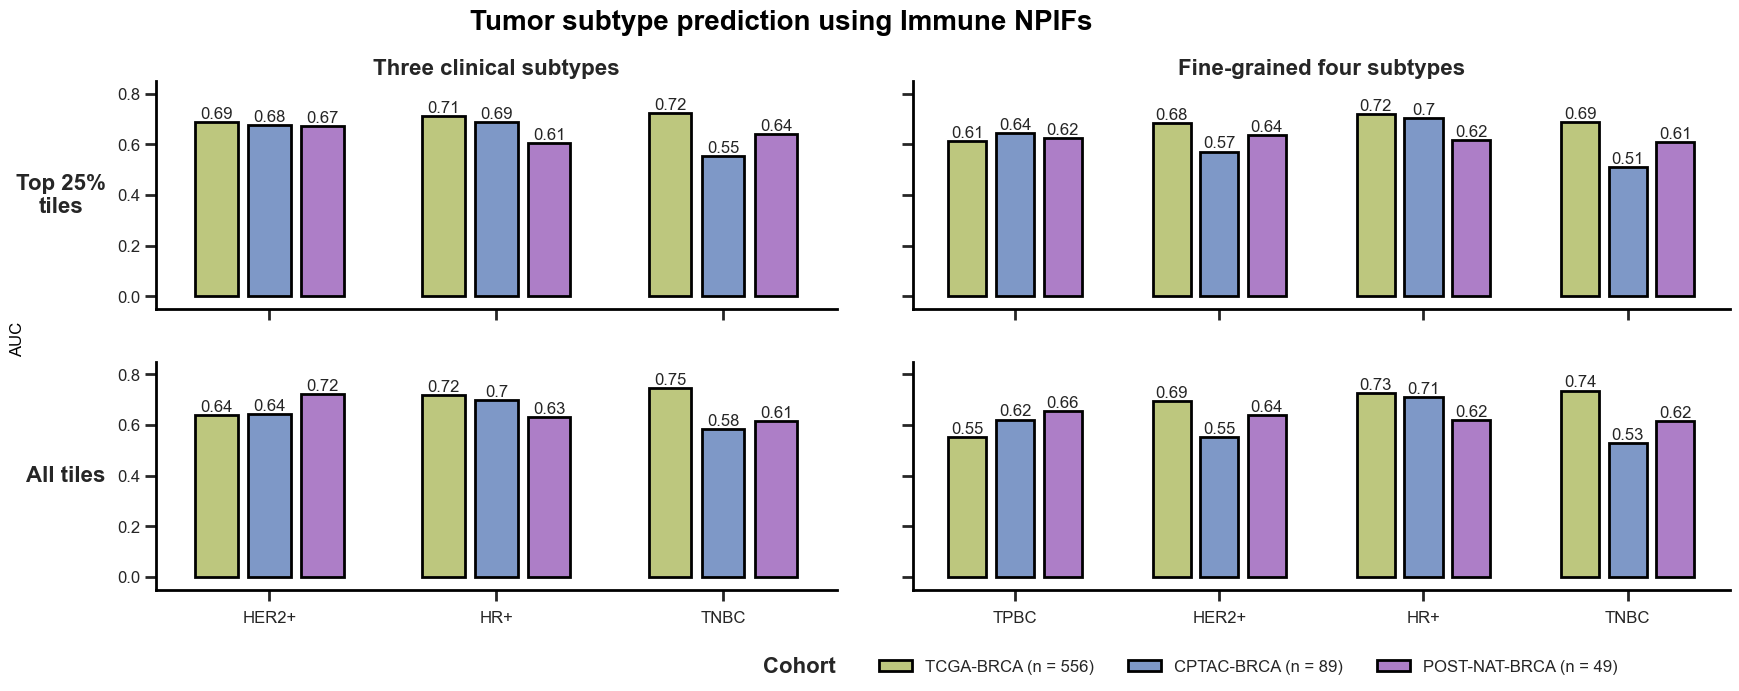

In [19]:
#%% make supp fig 5. 

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors       = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
                "#FFC72C", "#708090", "#A9A9A9", "#000000"]

panel_fonts  = {"weight": "bold", "size": 36, "color": "#000000"}
label_fonts  = {"weight": "regular", "size": 12, "color": "#000000"}
super_fonts  = {"weight": "bold", "size": 20, "color": "#000000"}
mega_fonts   = {"weight": "bold", "size": 24, "color": "#000000"}
legend_fonts = {"item" : {"size": 12, "weight": "regular"}, 
                "title": {"size": 16, "weight": "bold"}}

barprop      = {"linestyle": "-", "linewidth": 2, "edgecolor": colors[-1]}

## make composite plot.
figS5, axS5  = plt.subplots(figsize = (18, 7), nrows = 2, ncols = 2, width_ratios = [1, 1.2], 
                            sharex = False, sharey = True)
axS5         = dict(zip(list("ABCD"), axS5.ravel()))

fig_colorsS5 = [colors[k] for k in [4, 1, 3]]
for lbls, mdl, data in zip(["AB", "CD"], ["Top 25%\ntiles", "All tiles"], 
                           [fig_dataS5AB, fig_dataS5CD]):
    for lbl, col in zip(list(lbls), data.columns.levels[0]):
        ax, dat = axS5[lbl], data[col].dropna(how = "any", axis = 0)
        title   = col.replace("3-", "Three clinical ").replace("4-", "Fine-grained four ")
        ax = make_barplot3(data = dat, x = "subtype", y = "score", hue = "cohort", 
                           width = 0.7, gap = 0.2, bar_labels = True, colors = fig_colorsS5, 
                           legend = False, legend_title = "Cohort", ax = ax)
        ax.set_ylim([-0.05, 0.85]);
        if (lbl == "A") or (lbl == "B"):
            ax.set_xticklabels([""] * len(ax.get_xticklabels()));
            ax.set_title(title, wrap = True, y = 0.99, **legend_fonts["title"]);
        if (lbl == "A") or (lbl == "C"):
            ax.set_ylabel(mdl, labelpad = 8, rotation = 0, ha = "right", va = "center", 
                          ma = "center", **legend_fonts["title"]);
        
axS5["D"].legend(loc = (-0.05, -0.40), ncols = dat.cohort.nunique(), frameon = False, 
                 prop = legend_fonts["item"]);
figS5.text(x = 0.44, y = 0.043, s = "Cohort", wrap = True, **legend_fonts["title"]);
figS5.supylabel("AUC", wrap = True, x = 0.03, y = 0.52, ha = "center", va = "bottom", 
                ma = "center", **label_fonts);
figS5.suptitle("Tumor subtype prediction using Immune NPIFs", wrap = True, x = 0.45, y = 0.99, 
               linespacing = 1.5, **super_fonts);

figS5.tight_layout(h_pad = 3, w_pad = 3)
plt.show()


In [20]:
#%% save supp fig 5.

svdat = False
if svdat: 
    out_path  = "../../plots/v3/"
    out_file  = "All_Immune_NPIFs_results.pdf"
    out_data  = copy(figS5)
    out_param = {"dpi": 600, "transparent": True, "bbox_inches": "tight"}
    
    print("saving performance plots for Immune-NPIFs2...");    _dt = time()
    os.makedirs(out_path, exist_ok = True)                            # creates dir if doesn't exist already
    out_data.savefig(out_path + out_file, **out_param)
    print(out_file)
    _dt = time() - _dt;    print(f"done! elapsed time = {ceil(_dt)} sec.")
